Team Members:</br>
1. Piyush Gautam (pg2374)</br>
2. Jayanth Guduru (jg7162)</br>
3. Naveen Mallemala (nm3937)</br>

GitHub : https://github.com/pg2374/Pytorch-CIFAR10-RESNET18

#Pytorch on CIFAR-10 Dataset with Batch Normalisation and Dropout on Convolution Layers output after the activation function 

In [1]:
# # Install torchvision
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html

In [2]:
'''ResNet in PyTorch.
Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition.
[2] https://github.com/kuangliu/pytorch-cifar
[3] https://github.com/abhisikdar/RESNET18-CIFAR10 
[4] https://www.srose.biz/wp-content/uploads/2020/08/Batch-Size-and-Epochs.html  
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )
        # Dropout after Convolutional BasicBlock
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out




class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        self.dropout = nn.Dropout(0.25)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

In [3]:
# import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.backends.cudnn as cudnn

print('Is CUDA available', torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)
print('Device:', torch.device('cuda:0'))

Is CUDA available True
Torch 1.12.1+cu113 CUDA 11.3
Device: cuda:0


# Data Pre-processing</br>
1. Random cropping, with size 32x32 and padding 4</br>
2. Random horizontal flipping with a probability of 0.5</br>
3. Normalize each image’s RGB channel with mean() and std()</br>

In [4]:
data_path='../data/'
cifar=datasets.CIFAR10(data_path, train= True, download=True, transform=transforms.ToTensor())
cifar_val=datasets.CIFAR10(data_path, train=False, download= True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data/
Files already downloaded and verified


In [5]:
cifar_stack = torch.stack([img for img, _ in cifar], dim=3)
print('Shape of the CIFAR stack is',cifar_stack.shape)
mean= cifar_stack.view(3,-1).mean(dim=1)
std= cifar_stack.view(3,-1).std(dim=1)
print('Mean of training data is', mean)
print('Standard deviation of training data is', std)

Shape of the CIFAR stack is torch.Size([3, 32, 32, 50000])
Mean of training data is tensor([0.4914, 0.4822, 0.4465])
Standard deviation of training data is tensor([0.2470, 0.2435, 0.2616])


In [6]:
cifar_transformed = datasets.CIFAR10(data_path,train=True,download=False, transform=transforms.Compose([
                                                                                                      transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize(mean,std)
]))
cifar_val_transformed = datasets.CIFAR10(data_path,train=False,download=False, transform=transforms.Compose([
                                                                                                      transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),transforms.ToTensor(),transforms.Normalize(mean,std)
]))

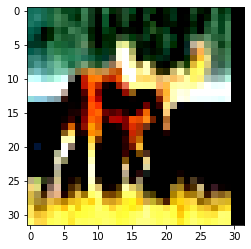

In [7]:
# View images

img, label = cifar_transformed[28]
plt.imshow(img.permute(1, 2, 0))    
plt.show()

#Varied the batch size for training dataset with other parameters fixed to measure the effect of batch size.</br>
Now, our Data is ready for Training.</br>


In [8]:
# Parameters
batch_size=[256,512]
val_batch_size=100
num_epochs=80
# learning_rate=0.1

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

Epoch no 1:	 Train Loss: 2.094596 	 Train Accuracy: 0.267540 	 Validation Accuracy: 0.269200
Epoch no 2:	 Train Loss: 1.633618 	 Train Accuracy: 0.411400 	 Validation Accuracy: 0.406000
Epoch no 3:	 Train Loss: 1.351006 	 Train Accuracy: 0.474960 	 Validation Accuracy: 0.474000
Epoch no 4:	 Train Loss: 1.373533 	 Train Accuracy: 0.548720 	 Validation Accuracy: 0.533600
Epoch no 5:	 Train Loss: 1.003003 	 Train Accuracy: 0.597240 	 Validation Accuracy: 0.581100
Epoch no 6:	 Train Loss: 0.888754 	 Train Accuracy: 0.661040 	 Validation Accuracy: 0.641000
Epoch no 7:	 Train Loss: 0.855906 	 Train Accuracy: 0.685800 	 Validation Accuracy: 0.666700
Epoch no 8:	 Train Loss: 0.612209 	 Train Accuracy: 0.710320 	 Validation Accuracy: 0.705100
Epoch no 9:	 Train Loss: 0.914594 	 Train Accuracy: 0.735800 	 Validation Accuracy: 0.719000
Epoch no 10:	 Train Loss: 0.591965 	 Train Accuracy: 0.756560 	 Validation Accuracy: 0.738800
Epoch no 11:	 Train Loss: 0.658923 	 Train Accuracy: 0.791540 	 Valid

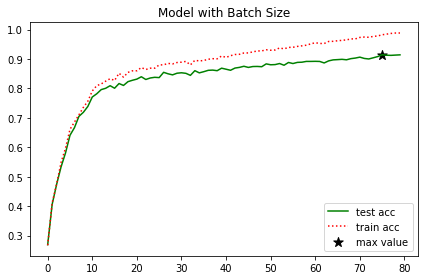

Epoch no 1:	 Train Loss: 1.948560 	 Train Accuracy: 0.181540 	 Validation Accuracy: 0.181000
Epoch no 2:	 Train Loss: 1.787604 	 Train Accuracy: 0.298280 	 Validation Accuracy: 0.304000
Epoch no 3:	 Train Loss: 1.633904 	 Train Accuracy: 0.387580 	 Validation Accuracy: 0.392000
Epoch no 4:	 Train Loss: 1.431077 	 Train Accuracy: 0.449280 	 Validation Accuracy: 0.449900
Epoch no 5:	 Train Loss: 1.258385 	 Train Accuracy: 0.528680 	 Validation Accuracy: 0.525100
Epoch no 6:	 Train Loss: 1.178314 	 Train Accuracy: 0.580940 	 Validation Accuracy: 0.572600
Epoch no 7:	 Train Loss: 0.995073 	 Train Accuracy: 0.634020 	 Validation Accuracy: 0.624000
Epoch no 8:	 Train Loss: 1.010588 	 Train Accuracy: 0.655040 	 Validation Accuracy: 0.639600
Epoch no 9:	 Train Loss: 0.926660 	 Train Accuracy: 0.683940 	 Validation Accuracy: 0.669100
Epoch no 10:	 Train Loss: 0.832603 	 Train Accuracy: 0.719280 	 Validation Accuracy: 0.711500
Epoch no 11:	 Train Loss: 0.796852 	 Train Accuracy: 0.733120 	 Valid

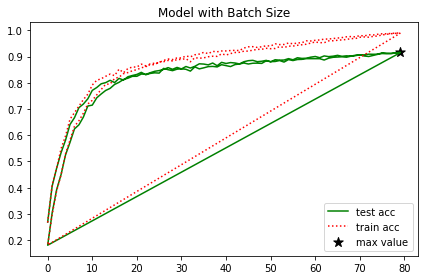

In [9]:
for batch_no in range(len(batch_size)):
  # Train/Test Data
  train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size[batch_no],shuffle=True, num_workers=4)
  train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=val_batch_size,shuffle=False, num_workers=4)
  val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False, num_workers=4)

  # Model
  resnet18 =ResNet18()
  resnet18=resnet18.to(dev)
  loss_func= torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

  for i in range(num_epochs):
    # Training
    for imgs, labels in train_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      out= resnet18(imgs)
      loss=loss_func(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    correct_val = 0
    total_val = 0
    correct_train_acc=0
    total_train_acc=0
    # Testing
    with torch.no_grad():
      for imgs, labels in val_loader:
        if dev is not None:
          imgs,labels=imgs.to(dev),labels.to(dev)
        outputs = resnet18(imgs) 
        _, predicted = torch.max(outputs, dim=1) 
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())
      val_acc.append(correct_val/total_val)

    # Compute Loss and Accuracy on training data
      for train_acc_imgs,train_acc_labels in train_acc_loader:
        if dev is not None:
          train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
        train_acc_out=resnet18(train_acc_imgs)
        _, train_acc_predicted = torch.max(train_acc_out, dim=1)
        total_train_acc += train_acc_labels.shape[0]
        correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
        # minibatch_acc = accuracy(train_acc, train_acc_labels,1)[0]
        # print("Top-1 training accuracy for minibatch", minibatch_acc)
      train_acc.append(correct_train_acc/total_train_acc)
      
      
      if correct_val/total_val > max_validation:
        max_validation=correct_val/total_val
        max_epoch=i
        torch.save(resnet18,'./scratch.pt' )
    epochs.append(i)

    

    if i%1==0:
      print("Epoch no %d:\t Train Loss: %f \t Train Accuracy: %f \t Validation Accuracy: %f" % (i+1, float(loss), correct_train_acc / total_train_acc, correct_val / total_val))
      # print("Train Accuracy: ", correct_train_acc / total_train_acc)
      # print("Validation Accuracy: ", correct_val / total_val)
    
    scheduler.step()

  print(max_validation)

  # Plot Train Accuracy vs Test Accuracy
  plt.plot(epochs, val_acc, label="test acc", color="green", linestyle='-')
  plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
  plt.scatter([max_epoch], [max_validation],color="black", marker="*", label="max value", s=100 )
  plt.title("Model with Batch Size")
  plt.legend()
  plt.tight_layout()
  plt.show()

#Varied the no of epochs with a fixed batch size to measure the effect of varying the epoch size.</br>



In [12]:
# Parameters
batch_size=512
val_batch_size=100
num_epochs=[100,120]
# learning_rate=2*1e-3

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

Epoch no 1:	 Train Loss: 1.751684 	 Train Accuracy: 0.368740 	 Validation Accuracy: 0.370400
Epoch no 2:	 Train Loss: 1.398206 	 Train Accuracy: 0.451180 	 Validation Accuracy: 0.450300
Epoch no 3:	 Train Loss: 1.130742 	 Train Accuracy: 0.549740 	 Validation Accuracy: 0.546500
Epoch no 4:	 Train Loss: 1.152687 	 Train Accuracy: 0.623100 	 Validation Accuracy: 0.612400
Epoch no 5:	 Train Loss: 0.927292 	 Train Accuracy: 0.674980 	 Validation Accuracy: 0.663300
Epoch no 6:	 Train Loss: 0.910996 	 Train Accuracy: 0.713820 	 Validation Accuracy: 0.700700
Epoch no 7:	 Train Loss: 0.702303 	 Train Accuracy: 0.737020 	 Validation Accuracy: 0.725600
Epoch no 8:	 Train Loss: 0.720909 	 Train Accuracy: 0.762020 	 Validation Accuracy: 0.749800
Epoch no 9:	 Train Loss: 0.563516 	 Train Accuracy: 0.782180 	 Validation Accuracy: 0.770900
Epoch no 10:	 Train Loss: 0.554902 	 Train Accuracy: 0.808700 	 Validation Accuracy: 0.791100
Epoch no 11:	 Train Loss: 0.615895 	 Train Accuracy: 0.817620 	 Valid

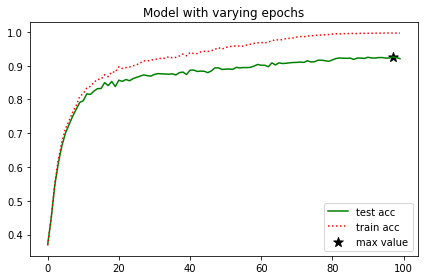

Epoch no 1:	 Train Loss: 2.288764 	 Train Accuracy: 0.123360 	 Validation Accuracy: 0.123100
Epoch no 2:	 Train Loss: 2.031219 	 Train Accuracy: 0.211080 	 Validation Accuracy: 0.210700
Epoch no 3:	 Train Loss: 1.813679 	 Train Accuracy: 0.267800 	 Validation Accuracy: 0.271900
Epoch no 4:	 Train Loss: 1.724874 	 Train Accuracy: 0.356120 	 Validation Accuracy: 0.350700
Epoch no 5:	 Train Loss: 1.533948 	 Train Accuracy: 0.398520 	 Validation Accuracy: 0.396100
Epoch no 6:	 Train Loss: 1.541005 	 Train Accuracy: 0.439780 	 Validation Accuracy: 0.434600
Epoch no 7:	 Train Loss: 1.394325 	 Train Accuracy: 0.489480 	 Validation Accuracy: 0.487400
Epoch no 8:	 Train Loss: 1.335881 	 Train Accuracy: 0.535880 	 Validation Accuracy: 0.527900
Epoch no 9:	 Train Loss: 1.100867 	 Train Accuracy: 0.574960 	 Validation Accuracy: 0.563500
Epoch no 10:	 Train Loss: 0.994325 	 Train Accuracy: 0.590480 	 Validation Accuracy: 0.583200
Epoch no 11:	 Train Loss: 0.908978 	 Train Accuracy: 0.635380 	 Valid

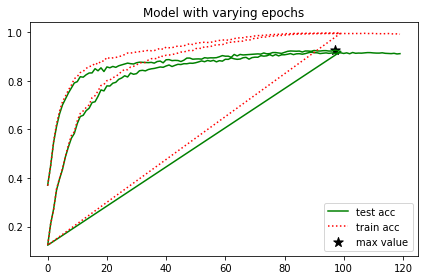

In [13]:
for epoch_no in range(len(num_epochs)):
  # Train/Test Data
  train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size,shuffle=True, num_workers=4)
  train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=val_batch_size,shuffle=False, num_workers=4)
  val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False, num_workers=4)

  # Model
  resnet18 =ResNet18()
  resnet18=resnet18.to(dev)
  loss_func= torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(resnet18.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

  for i in range(num_epochs[epoch_no]):
    # Training
    for imgs, labels in train_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      out= resnet18(imgs)
      loss=loss_func(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    correct_val = 0
    total_val = 0
    correct_train_acc=0
    total_train_acc=0
    # Testing
    with torch.no_grad():
      for imgs, labels in val_loader:
        if dev is not None:
          imgs,labels=imgs.to(dev),labels.to(dev)
        outputs = resnet18(imgs) 
        _, predicted = torch.max(outputs, dim=1) 
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())
      val_acc.append(correct_val/total_val)

    # Compute Loss and Accuracy on training data
      for train_acc_imgs,train_acc_labels in train_acc_loader:
        if dev is not None:
          train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
        train_acc_out=resnet18(train_acc_imgs)
        _, train_acc_predicted = torch.max(train_acc_out, dim=1)
        total_train_acc += train_acc_labels.shape[0]
        correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
        # minibatch_acc = accuracy(train_acc, train_acc_labels,1)[0]
        # print("Top-1 training accuracy for minibatch", minibatch_acc)
      train_acc.append(correct_train_acc/total_train_acc)
      
      
      if correct_val/total_val > max_validation:
        max_validation=correct_val/total_val
        max_epoch=i
    epochs.append(i)

    

    if i%1==0:
      print("Epoch no %d:\t Train Loss: %f \t Train Accuracy: %f \t Validation Accuracy: %f" % (i+1, float(loss), correct_train_acc / total_train_acc, correct_val / total_val))
    
    scheduler.step()

  print(max_validation)

  # Plot Train Accuracy vs Test Accuracy
  plt.plot(epochs, val_acc, label="test acc", color="green", linestyle='-')
  plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
  plt.scatter([max_epoch], [max_validation],color="black", marker="*", label="max value", s=100 )
  plt.title("Model with varying epochs")
  plt.legend()
  plt.tight_layout()
  plt.show()

#Varied the learning rate [0.1, 0.01, 0.001, 0.0001] on fixed batch size and fixed no of epoch to observe the effect of varying the epoch size</br>
Results for lr = 0.1 have been shown above  

In [14]:
# Parameters
batch_size=512
val_batch_size=100
num_epochs=100
learning_rate=[0.01, 0.001, 0.0001]

dev=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

max_validation = 0
max_epoch=0
val_acc=[]
train_acc=[]
epochs=[]

Epoch no 1:	 Train Loss: 1.552453 	 Train Accuracy: 0.430000 	 Validation Accuracy: 0.435700
Epoch no 2:	 Train Loss: 1.305971 	 Train Accuracy: 0.545500 	 Validation Accuracy: 0.536800
Epoch no 3:	 Train Loss: 1.070486 	 Train Accuracy: 0.625580 	 Validation Accuracy: 0.620700
Epoch no 4:	 Train Loss: 0.993566 	 Train Accuracy: 0.668940 	 Validation Accuracy: 0.658300
Epoch no 5:	 Train Loss: 0.869960 	 Train Accuracy: 0.693260 	 Validation Accuracy: 0.679500
Epoch no 6:	 Train Loss: 0.712457 	 Train Accuracy: 0.718560 	 Validation Accuracy: 0.703500
Epoch no 7:	 Train Loss: 0.717937 	 Train Accuracy: 0.754360 	 Validation Accuracy: 0.734200
Epoch no 8:	 Train Loss: 0.711351 	 Train Accuracy: 0.777960 	 Validation Accuracy: 0.763200
Epoch no 9:	 Train Loss: 0.624291 	 Train Accuracy: 0.794660 	 Validation Accuracy: 0.770600
Epoch no 10:	 Train Loss: 0.481533 	 Train Accuracy: 0.796740 	 Validation Accuracy: 0.773600
Epoch no 11:	 Train Loss: 0.501585 	 Train Accuracy: 0.814840 	 Valid

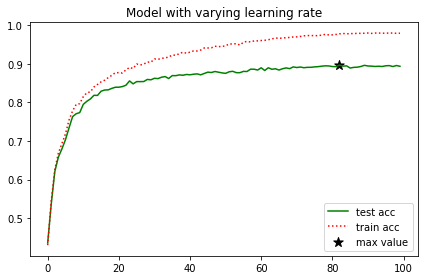

Epoch no 1:	 Train Loss: 1.963967 	 Train Accuracy: 0.264280 	 Validation Accuracy: 0.268300
Epoch no 2:	 Train Loss: 1.822428 	 Train Accuracy: 0.327560 	 Validation Accuracy: 0.338500
Epoch no 3:	 Train Loss: 1.706578 	 Train Accuracy: 0.375440 	 Validation Accuracy: 0.382100
Epoch no 4:	 Train Loss: 1.523314 	 Train Accuracy: 0.405200 	 Validation Accuracy: 0.406100
Epoch no 5:	 Train Loss: 1.600870 	 Train Accuracy: 0.432240 	 Validation Accuracy: 0.434100
Epoch no 6:	 Train Loss: 1.575444 	 Train Accuracy: 0.454020 	 Validation Accuracy: 0.453900
Epoch no 7:	 Train Loss: 1.387980 	 Train Accuracy: 0.480840 	 Validation Accuracy: 0.488100
Epoch no 8:	 Train Loss: 1.388710 	 Train Accuracy: 0.499600 	 Validation Accuracy: 0.499900
Epoch no 9:	 Train Loss: 1.287985 	 Train Accuracy: 0.514340 	 Validation Accuracy: 0.508800
Epoch no 10:	 Train Loss: 1.271625 	 Train Accuracy: 0.536240 	 Validation Accuracy: 0.524500
Epoch no 11:	 Train Loss: 1.290402 	 Train Accuracy: 0.552660 	 Valid

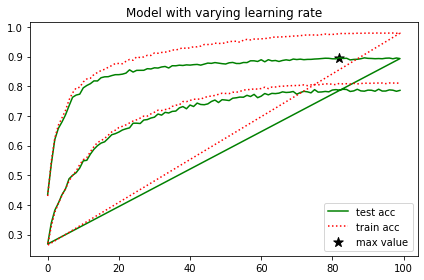

Epoch no 1:	 Train Loss: 2.228647 	 Train Accuracy: 0.163520 	 Validation Accuracy: 0.164500
Epoch no 2:	 Train Loss: 2.178976 	 Train Accuracy: 0.186600 	 Validation Accuracy: 0.190400
Epoch no 3:	 Train Loss: 2.122298 	 Train Accuracy: 0.210300 	 Validation Accuracy: 0.217100
Epoch no 4:	 Train Loss: 2.059765 	 Train Accuracy: 0.232280 	 Validation Accuracy: 0.233800
Epoch no 5:	 Train Loss: 2.029768 	 Train Accuracy: 0.242540 	 Validation Accuracy: 0.250100
Epoch no 6:	 Train Loss: 1.986823 	 Train Accuracy: 0.254760 	 Validation Accuracy: 0.253200
Epoch no 7:	 Train Loss: 1.935454 	 Train Accuracy: 0.263020 	 Validation Accuracy: 0.269400
Epoch no 8:	 Train Loss: 1.930615 	 Train Accuracy: 0.272640 	 Validation Accuracy: 0.279600
Epoch no 9:	 Train Loss: 1.915504 	 Train Accuracy: 0.282160 	 Validation Accuracy: 0.285600
Epoch no 10:	 Train Loss: 1.889218 	 Train Accuracy: 0.287020 	 Validation Accuracy: 0.293700
Epoch no 11:	 Train Loss: 1.885170 	 Train Accuracy: 0.298220 	 Valid

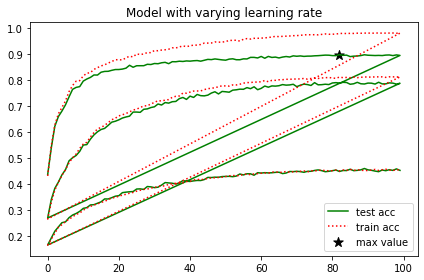

In [15]:
for lr_no in range(len(learning_rate)):
  # Train/Test Data
  train_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=batch_size,shuffle=True, num_workers=4)
  train_acc_loader=torch.utils.data.DataLoader(cifar_transformed,batch_size=val_batch_size,shuffle=False, num_workers=4)
  val_loader = torch.utils.data.DataLoader(cifar_val_transformed, batch_size=val_batch_size, shuffle=False, num_workers=4)

  # Model
  resnet18 =ResNet18()
  resnet18=resnet18.to(dev)
  loss_func= torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(resnet18.parameters(), lr=learning_rate[lr_no], momentum=0.9, weight_decay=5e-4)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

  for i in range(num_epochs):
    # Training
    for imgs, labels in train_loader:
      if dev is not None:
        imgs,labels=imgs.to(dev),labels.to(dev)
      out= resnet18(imgs)
      loss=loss_func(out,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    
    correct_val = 0
    total_val = 0
    correct_train_acc=0
    total_train_acc=0
    # Testing
    with torch.no_grad():
      for imgs, labels in val_loader:
        if dev is not None:
          imgs,labels=imgs.to(dev),labels.to(dev)
        outputs = resnet18(imgs) 
        _, predicted = torch.max(outputs, dim=1) 
        total_val += labels.shape[0]
        correct_val += int((predicted == labels).sum())
      val_acc.append(correct_val/total_val)

    # Compute Loss and Accuracy on training data
      for train_acc_imgs,train_acc_labels in train_acc_loader:
        if dev is not None:
          train_acc_imgs,train_acc_labels=train_acc_imgs.to(dev),train_acc_labels.to(dev)
        train_acc_out=resnet18(train_acc_imgs)
        _, train_acc_predicted = torch.max(train_acc_out, dim=1)
        total_train_acc += train_acc_labels.shape[0]
        correct_train_acc += int((train_acc_predicted == train_acc_labels).sum())
        # minibatch_acc = accuracy(train_acc, train_acc_labels,1)[0]
        # print("Top-1 training accuracy for minibatch", minibatch_acc)
      train_acc.append(correct_train_acc/total_train_acc)
      
      
      if correct_val/total_val > max_validation:
        max_validation=correct_val/total_val
        max_epoch=i
    epochs.append(i)

    

    if i%1==0:
      print("Epoch no %d:\t Train Loss: %f \t Train Accuracy: %f \t Validation Accuracy: %f" % (i+1, float(loss), correct_train_acc / total_train_acc, correct_val / total_val))
    
    scheduler.step()

  print(max_validation)

  # Plot Train Accuracy vs Test Accuracy
  plt.plot(epochs, val_acc, label="test acc", color="green", linestyle='-')
  plt.plot(epochs, train_acc, label="train acc", color="red",linestyle=':')
  plt.scatter([max_epoch], [max_validation],color="black", marker="*", label="max value", s=100 )
  plt.title("Model with varying learning rate")
  plt.legend()
  plt.tight_layout()
  plt.show()